RollingBall:玩家（或智能体）通过施加力控制小球，从网格起点（[0.2*宽, 0.2*高]）移动到目标点（[0.8*宽, 0.8*高]）。

核心特点：
- **环境**：10x10 网格（可调），小球受力、摩擦（系数 0.0046）、边界碰撞（恢复系数 0.8）影响，速度上限 5.0。
- **动作**：连续力（[-0.1, 0.1]），可离散化为 5x5 动作（[-0.8, -0.4, 0, 0.4, 0.8]）并展平为 25 个动作。
- **奖励**：每步 -2.0，撞墙 -10.0，到达目标 +300.0。
- **渲染**：Pygame 显示蓝色小球、紫色目标，可选灰色轨迹，300x300 像素窗口。

In [2]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from gym.utils.env_checker import check_env
from RL_DQN_Class import DQN,ReplayBuffer
from gym.wrappers import TimeLimit
from two_dimensional_rolling_motion import RollingBall, DiscreteActionWrapper, FlattenActionSpaceWrapper

d:\py\Anaconda3\envs\DL_pytorch_gpu\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 19: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s, episode=1950, return=146.400]


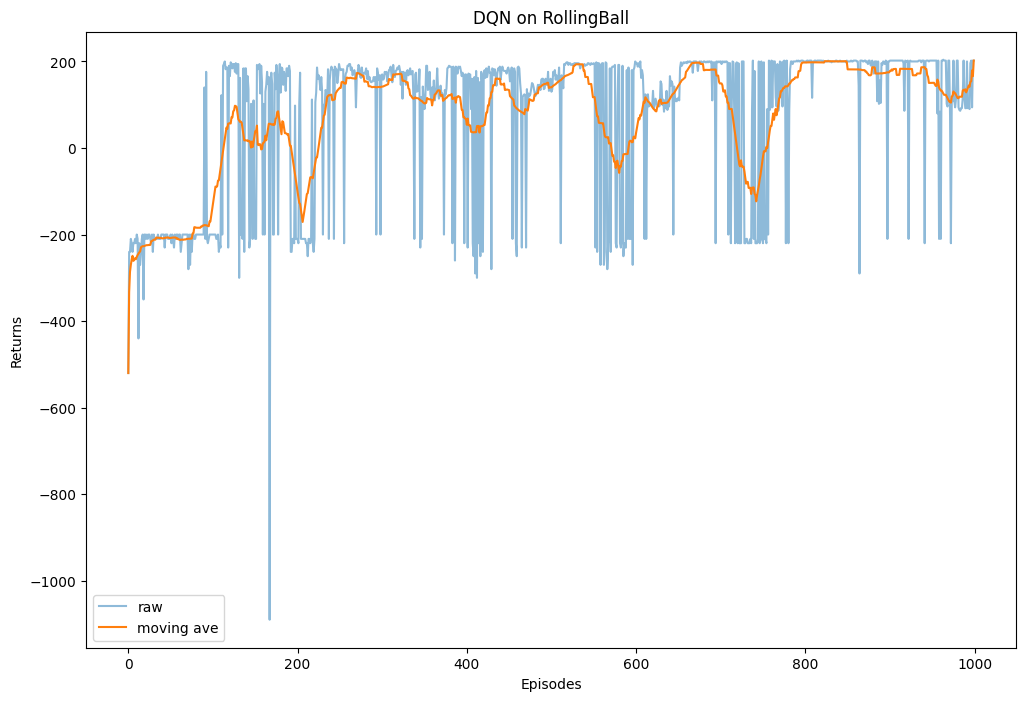

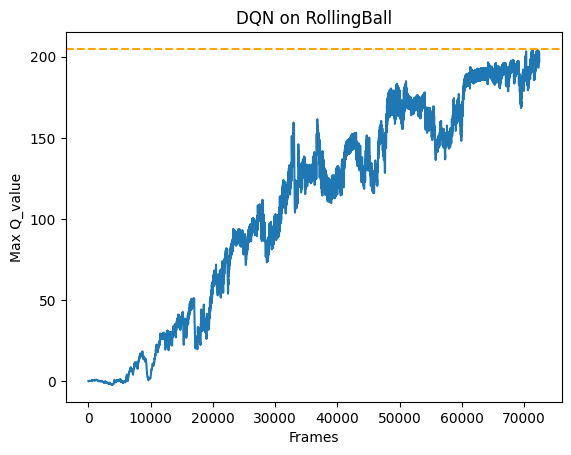

In [3]:
if __name__ == "__main__":
    def moving_average(a, window_size):
        ''' 生成序列 a 的滑动平均序列 '''
        # 计算滑动平均，平滑序列（如回合回报），便于绘图时观察趋势
        # 参数：a（输入序列，如回报列表），window_size（窗口大小，后续设为 29）
        cumulative_sum = np.cumsum(np.insert(a, 0, 0))
        # 计算累积和，插入 0 便于差分计算窗口平均值
        middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
        # 中间部分：通过累积和差分计算窗口平均值
        r = np.arange(1, window_size-1, 2)
        # 生成奇数序列 [1, 3, 5, ...]，用于处理开头和结尾的小窗口
        begin = np.cumsum(a[:window_size-1])[::2] / r
        # 开头部分：计算前 window_size-1 个元素的小窗口平均值
        end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
        # 结尾部分：计算最后 window_size-1 个元素的反向小窗口平均值，翻转对齐
        return np.concatenate((begin, middle, end))
        # 拼接开头、中间、结尾，返回等长滑动平均序列

    def set_seed(env, seed=42):
        ''' 设置随机种子 '''
        # 设置随机种子，确保环境和算法行为一致，实验可重复
        env.action_space.seed(seed)
        # 为动作空间设置种子，确保动作采样一致
        env.reset(seed=seed)
        # 重置环境，应用种子，确保初始状态一致
        random.seed(seed)
        # 设置 Python random 模块种子，用于随机动作选择
        np.random.seed(seed)
        # 设置 NumPy 随机种子，用于数组操作和采样
        torch.manual_seed(seed)
        # 设置 PyTorch 种子，确保神经网络初始化和训练一致

    state_dim = 4                               # 环境观测维度
    # 状态维度为 4，对应 RollingBall 环境的观测 [x_position, y_position, x_velocity, y_velocity]
    # 参考 GridWorld.py 中 observation_space 定义
    action_dim = 1                              # 环境动作维度
    # 动作维度为 1，因动作空间被展平为 Discrete(100)（单一整数）
    action_bins = 10                            # 动作离散 bins 数量
    # 每个动作维度（x 和 y 方向的力）离散化为 10 个 bins
    action_range = action_bins * action_bins    # 环境动作空间大小
    # 总动作数为 10x10=100，表示离散化后的动作空间
    hidden_dim = 128                             # 神经网络隐藏层大小
    # DQN 的 Q 网络隐藏层包含 32 个单元
    lr = 1e-3                                   # 学习率
    # 学习率 0.001，用于 Adam 优化器更新 Q 网络
    num_episodes = 1000                         # 总训练回合数
    # 智能体进行 1000 次回合训练
    gamma = 0.99                                # 折扣因子
    # 折扣因子 0.99，平衡当前和未来奖励，参考 Book-all-in-one.pdf 第 1.1 节
    epsilon_start = 0.01                        # 初始探索率
    # epsilon-greedy 策略初始探索概率为 1%
    epsilon_end = 0.001                         # 最终探索率
    # 探索概率衰减至 0.1%
    target_update = 1000                        # 目标网络更新频率
    # 每 1000 步更新目标 Q 网络，参考 Book-all-in-one.pdf 第 8.4.1 节
    buffer_size = 10000                         # 回放缓冲区容量
    # 可存储 10000 条经验（状态、动作、奖励、下一状态、终止标志）
    minimal_size = 5000                         # 训练前最小缓冲区大小
    # 缓冲区需至少 5000 条经验才开始训练
    batch_size = 128                            # 批量大小
    # 每次训练从缓冲区采样 128 条经验
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # 优先使用 GPU（CUDA），否则使用 CPU，加速神经网络计算

    # 构建环境
    env = RollingBall(width=5, height=5, show_epi=True)
    # 创建 5x5 的 RollingBall 环境，显示小球轨迹
    # 参考 GridWorld.py：
    # - 初始位置：(1, 1)（0.2 * 5）
    # - 目标位置：(4, 4)（0.8 * 5）
    # - 奖励：每步 -2.0，撞墙 -10.0，目标 +300.0
    # - 动作空间：Box([-0.1, 0.1], shape=(2,))，x 和 y 方向的力
    # - 观测空间：Box([0, 0, -5, -5], [5, 5, 5, 5])，[x, y, vx, vy]
    env = FlattenActionSpaceWrapper(DiscreteActionWrapper(env, bins=10))
    # 包装动作空间：
    # 1. DiscreteActionWrapper（参考 Hashposotion.py）：
    #    - 将连续动作离散化为 MultiDiscrete([10, 10])
    #    - 每个维度 10 个 bins，映射到 [-1, 1]，步长 0.2
    # 2. FlattenActionSpaceWrapper：
    #    - 展平为 Discrete(100)，动作索引 0-99
    env = TimeLimit(env, 100)
    # 限制每回合最大 100 步，超限返回 truncated=True
    check_env(env.unwrapped)
    # 检查原始 RollingBall 环境是否符合 Gym 规范
    set_seed(env, seed=42)
    # 设置环境随机种子，确保一致性

    # 构建代理和回放缓冲区
    replay_buffer = ReplayBuffer(buffer_size)
    # 创建回放缓冲区，容量 10000，存储经验 (state, action, reward, next_state, done)
    agent = DQN(state_dim, hidden_dim, action_dim, action_range, lr, gamma, epsilon_start, target_update, device)
    # 创建 DQN 代理（假设 DQN 类已定义）
    # 配置：4 维状态输入，100 个动作输出，32 单元隐藏层，学习率 0.001，折扣因子 0.99
    # 功能：epsilon-greedy 动作选择，Q 网络更新，目标网络定期同步

    # 随机动作填充回放缓冲区
    state, _ = env.reset()
    # 重置环境，获取初始状态
    while replay_buffer.size() <= minimal_size:
        action = env.action_space.sample()
        # 随机选择动作（0-99）
        next_state, reward, terminated, truncated, _ = env.step(action)
        # 执行动作，获取下一状态、奖励、终止标志等
        replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
        # 存储经验，done 表示回合是否结束
        state = next_state
        # 更新状态
        if terminated or truncated:
            env.render()
            # 回合结束时渲染，显示小球轨迹
            state, _ = env.reset()
            # 重置环境
        #print(replay_buffer.size())
        # （注释掉）可打印缓冲区大小，监控填充进度

    # 开始训练
    return_list = []
    # 存储每回合总回报
    max_q_value_list = []
    # 存储平滑的最大 Q 值
    max_q_value = 0
    # 用于平滑 Q 值的初始值
    for i in range(20):
        # 分 20 次迭代，每迭代 50 回合，共 1000 回合
        with tqdm(total=int(num_episodes / 20), desc='Iteration %d' % i) as pbar:
            # 使用 tqdm 显示进度条
            for i_episode in range(int(num_episodes / 20)):
                # 每迭代 50 回合
                episode_return = 0
                # 初始化回合回报
                state, _ = env.reset()
                # 重置环境
                while True:
                    # 计算并平滑最大 Q 值
                    max_q_value = agent.max_q_value_of_given_state(state) * 0.005 + max_q_value * 0.995
                    # 使用指数平滑，权重 0.005（新值）和 0.995（旧值）
                    max_q_value_list.append(max_q_value)
                    # 记录 Q 值

                    # 选择并执行动作
                    action = agent.take_action(state)
                    # 使用 epsilon-greedy 策略选择动作
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    # 执行动作，获取结果

                    # 更新回放缓冲区
                    replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
                    # 存储新经验

                    # 训练 Q 网络
                    assert replay_buffer.size() > minimal_size
                    # 确保缓冲区足够大
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    # 采样 128 条经验
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    # 组织批量数据
                    agent.update(transition_dict)
                    # 更新 Q 网络，计算 Q 学习损失并优化

                    state = next_state
                    # 更新状态
                    episode_return += reward
                    # 累加回报

                    if terminated or truncated:
                        env.render()
                        # 回合结束时渲染
                        break
                    #env.render()
                    # （注释掉）可每步渲染，但会减慢训练

                return_list.append(episode_return)
                # 记录回合回报
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                    # 每 10 回合更新进度条，显示回合数和最近 10 次平均回报
                pbar.update(1)
                # 更新进度条

        #env.render()
        # （注释掉）迭代结束时可渲染
        agent.epsilon += (epsilon_end - epsilon_start) / 10
        # 调整 epsilon，注意：应为衰减，可能需改为 agent.epsilon = epsilon_start + (epsilon_end - epsilon_start) * i / 19

    # 显示训练结果
    mv_return_list = moving_average(return_list, 29)
    # 计算 29 步滑动平均回报
    episodes_list = list(range(len(return_list)))
    # 生成回合索引
    plt.figure(figsize=(12,8))
    # 创建 12x8 英寸画布
    plt.plot(episodes_list, return_list, label='raw', alpha=0.5)
    # 绘制原始回报，半透明
    plt.plot(episodes_list, mv_return_list, label='moving ave')
    # 绘制平滑回报
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title(f'{agent._get_name()} on RollingBall')
    # 设置标题，包含代理名称（如 DQN）
    plt.legend()
    # 显示图例
    plt.savefig(f'./result/{agent._get_name()}.png')
    # 保存回报曲线
    plt.show()
    # 显示图像

    # 显示最大 Q 值
    frames_list = list(range(len(max_q_value_list)))
    # 生成帧索引
    plt.plot(frames_list, max_q_value_list)
    # 绘制平滑 Q 值曲线
    plt.axhline(max(max_q_value_list), c='orange', ls='--')
    # 标记最大 Q 值
    plt.xlabel('Frames')
    plt.ylabel('Max Q_value')
    plt.title(f'{agent._get_name()} on RollingBall')
    # 设置标题
    plt.savefig(f'./result/{agent._get_name()}_MaxQ.png')
    # 保存 Q 值曲线
    plt.show()
    # 显示图像